# Make an inventory of downloaded data
- Spatial Extent
- Temporal Extent
- type of data

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 10})

import hvplot
import hvplot.pandas
import geoviews as gv

In [2]:
%matplotlib inline

In [3]:
regions = [f for f in os.listdir(f'/fs/project/howat.4/icesat2/antarctica_ATL06') if f.startswith('rema_')]

In [4]:
print(regions)

['rema_07_qml_ne', 'rema_08_qml_se', 'rema_09_qml_nw', 'rema_11_amery_shelf', 'rema_13_wilkes_land_ne', 'rema_17_wilkes_land_nw', 'rema_21_mbl_north', 'rema_02_peninsula_north', 'rema_03_peninsula_south', 'rema_04_ronne_shelf', 'rema_05_ellsworth_land', 'rema_06_luitpold_coast', 'rema_15_wilkes_land_nc', 'rema_10_qml_sw', 'rema_12_american_highland', 'rema_14_wilkes_land_se', 'rema_16_wilkes_land_sc', 'rema_19_victoria_land', 'rema_18_wilkes_land_sw', 'rema_22_mbl_central', 'rema_23_siple_coast', 'rema_20_ross_shelf', 'rema_24_ctam', 'rema_27_qml_south', 'rema_25_mbl_south', 'rema_01_subantarctic_islands']


In [5]:
regions = ['rema_07_qml_ne', 'rema_08_qml_se', 'rema_09_qml_nw', 'rema_11_amery_shelf', 'rema_13_wilkes_land_ne', 'rema_17_wilkes_land_nw', 'rema_02_peninsula_north', 'rema_03_peninsula_south', 'rema_04_ronne_shelf', 'rema_05_ellsworth_land', 'rema_06_luitpold_coast', 'rema_15_wilkes_land_nc', 'rema_10_qml_sw', 'rema_12_american_highland', 'rema_14_wilkes_land_se', 'rema_16_wilkes_land_sc', 'rema_19_victoria_land', 'rema_18_wilkes_land_sw', 'rema_01_subantarctic_islands']
regions

['rema_07_qml_ne',
 'rema_08_qml_se',
 'rema_09_qml_nw',
 'rema_11_amery_shelf',
 'rema_13_wilkes_land_ne',
 'rema_17_wilkes_land_nw',
 'rema_02_peninsula_north',
 'rema_03_peninsula_south',
 'rema_04_ronne_shelf',
 'rema_05_ellsworth_land',
 'rema_06_luitpold_coast',
 'rema_15_wilkes_land_nc',
 'rema_10_qml_sw',
 'rema_12_american_highland',
 'rema_14_wilkes_land_se',
 'rema_16_wilkes_land_sc',
 'rema_19_victoria_land',
 'rema_18_wilkes_land_sw',
 'rema_01_subantarctic_islands']

In [6]:
short_name = 'ATL06'
# region = regions[0]#'rema_04_ronne_shelf'#'rema_27_qml_south'
for region in regions:
    icesat2_path = f'/fs/project/howat.4/icesat2/antarctica_{short_name}/{region}'
    files = os.listdir(f'{icesat2_path}')
    outline = gpd.read_file(f'{icesat2_path}/outline.shp')
    shp_ext = 'shp' #'.gpkg'
    shp_files = [f for f in files if f.endswith(f'.{shp_ext}') and 'ATL06' in f]
    
    # dict and list to temporarily hold data for geodataframe creation
    shp_dict = {}
    flist = []
    chlist = []
    pt_count = []
    for shp in shp_files:
        fname = shp.split('.shp')[0]
        gdf = gpd.read_file(f'{icesat2_path}/{fname}.{shp_ext}', parse_dates=True)
        ch = gdf.geometry.unary_union.convex_hull
        ch = gpd.GeoSeries(ch, crs=outline.crs)
        ch = list(ch.geometry)[0]
        flist.append(fname)
        chlist.append(ch)
        pt_count.append(len(gdf))
    shp_dict['name'] = flist
    shp_dict['pt_count'] = pt_count

    shp_dict['geometry'] = chlist
    df = pd.DataFrame.from_dict(shp_dict)
    gdf1 = gpd.GeoDataFrame(df, geometry='geometry', crs=outline.crs)
    # Add more attributes
    gdf1['date'] = gdf1.name.apply(lambda x: x.split('_')[2][:8]) #pd.to_datetime() but datetime field can't be saved to esri file; DriverSupportError: ESRI Shapefile does not support datetime fields
    gdf1.head()
    gdf1.to_file(f'/fs/project/howat.4/icesat2/prototyping/metadata_antarctica/{region}.shp')

    ax = outline.plot(alpha=.4, figsize=(12, 12))
    gdf1.plot(ax=ax, color='r')
    plt.title(region)
    plt.savefig(f'/fs/project/howat.4/icesat2/prototyping/metadata_antarctica/{region}.png')
    plt.close(plt.gcf())

ValueError: Cannot write empty DataFrame to file.

Text(0.5, 1.0, 'rema_07_qml_ne')

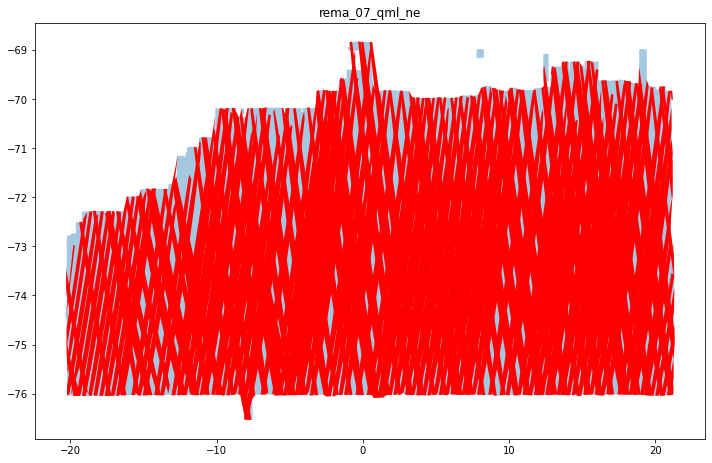

In [11]:
ax = outline.plot(alpha=.4, figsize=(12, 12))
gdf1.plot(ax=ax, color='r')
plt.title(region)


In [15]:
fig = base * outline.hvplot(geo=True, alpha=.2) * gdf1.hvplot(geo=True, alpha=0.7, width=800, height=500) #color='strip', 
base = gv.tile_sources.ESRI
fig

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

In [14]:
# Load ATL08 parsed data
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.{shp_ext}', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
# df = df[df.q_flag==0]
# gdf = gdf[gdf.q_flag==0]

gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

137438 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [15]:
len(df)

137438

In [50]:
ch = gdf.geometry.unary_union.convex_hull
ch = gpd.GeoSeries(ch, crs=outline.crs)


<AxesSubplot:>

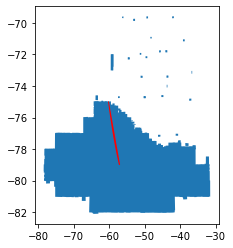

In [47]:
ax =outline.plot()
ch.plot(ax=ax,color='r')

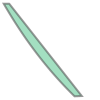

In [16]:
ch.plot('')

In [17]:
!echo $TMPDIR

/tmp//2711200.unity-1.asc.ohio-state.edu


In [18]:
y = gdf.geometry.unary_union.envelope
print(y)

POLYGON ((-60.29405695582228 -79.00604159779911, -56.89335866689649 -79.00604159779911, -56.89335866689649 -74.97437839289114, -60.29405695582228 -74.97437839289114, -60.29405695582228 -79.00604159779911))


In [19]:
x = gpd.GeoDataFrame([ch])

In [20]:
# x.hvplot(geo=True, color='strip', alpha=0.7, width=400, height=500)
type(x)

geopandas.geodataframe.GeoDataFrame